In [1]:
import pandas as pd
import numpy as np
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score

In [ ]:
# if save session
import dill
dill.dump_session('cytof_notebook_env.db')

In [ ]:
# restore session
import dill
dill.load_session('cytof_notebook_env.db')

## Tidy the dataset
- Use log2 for the channels
- For each call/round of Tribus, perform always outlier truncation, set the maximum to the 99 percentile
- For each call/round of Tribus, perform always Z-score and then Min-Max transformation in all the channels

In [2]:
# read input files
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\origin_data\\cellData.csv")
sample_data.columns.values

array(['SampleID', 'cellLabelInImage', 'cellSize', 'C', 'Na', 'Si', 'P',
       'Ca', 'Fe', 'dsDNA', 'Vimentin', 'SMA', 'Background', 'B7H3',
       'FoxP3', 'Lag3', 'CD4', 'CD16', 'CD56', 'OX40', 'PD1', 'CD31',
       'PD-L1', 'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 'CD163',
       'CD68', 'CSF-1R', 'CD8', 'CD3', 'IDO', 'Keratin17', 'CD63',
       'CD45RO', 'CD20', 'p53', 'Beta catenin', 'HLA-DR', 'CD11b', 'CD45',
       'H3K9ac', 'Pan-Keratin', 'H3K27me3', 'phospho-S6', 'MPO',
       'Keratin6', 'HLA_Class_1', 'Ta', 'Au', 'tumorYN', 'tumorCluster',
       'Group', 'immuneCluster', 'immuneGroup'], dtype=object)

In [3]:
sample_data = sample_data.fillna(0)
sample_data

SampleID  cellLabelInImage  cellSize  C       Na        Si        P   
0              1                 2       146  0 -0.59061  0.875220 -2.57650  \
1              1                 3       102  0 -0.49870  0.017464 -1.22490   
2              1                 4        43  0 -1.48730 -0.630440 -1.91070   
3              1                 5       211  0 -1.00530 -0.532270 -1.74300   
4              1                 6       177  0  0.15803 -0.710290  0.51737   
...          ...               ...       ... ..      ...       ...      ...   
201651        44              1402       198  0  3.79060  1.212600  0.82351   
201652        44              1403       111  0  3.89980  0.119160  1.03970   
201653        44              1404       100  0  3.54820 -0.578650 -2.12650   
201654        44              1405       129  0  3.59890  2.929000 -1.77210   
201655        44              1406       103  0  3.85330  0.749790 -1.15650   

              Ca        Fe     dsDNA  ...      MPO  Keratin6  HLA_Class_1   
0      -0.806060 -0.234400 -1.308000  ... -0.13903  -0.41883     -0.53738  \
1      -0.501520 -1.341200  0.522570  ... -0.13903  -0.52769     -0.62060   
2      -1.228000 -1.393700 -1.782200  ... -0.13903   0.18774     -1.75050   
3      -0.944850 -1.099600 -0.057906  ... -0.13903  -0.30976     -0.52445   
4      -0.096251 -1.052600  0.355020  ... -0.13903  -0.52769     -0.99773   
...          ...       ...       ...  ...      ...       ...          ...   
201651  1.194900  0.617350  1.530700  ... -0.13903  -0.34334     -1.74170   
201652  1.089000 -0.075447  1.428700  ... -0.13903  -0.52769     -1.77350   
201653  0.803610 -0.788880  0.566460  ... -0.13903  -0.52769     -1.85290   
201654  1.375700 -0.301130 -1.198100  ... -0.13903  -0.52769     -1.85290   
201655  1.691600  0.265730  1.399300  ... -0.13903  -0.49681     -1.85290   

             Ta        Au  tumorYN  tumorCluster  Group  immuneCluster   
0       2.48110  2.326600        1             0      6              0  \
1       2.30430  2.187100        0             0      2             46   
2       1.39330  1.478200        1             0      6              0   
3       1.88680  1.586200        1             0      6              0   
4      -0.51027 -0.496270        0             0      2             75   
...         ...       ...      ...           ...    ...            ...   
201651 -0.60616 -0.049150        1             0      6              0   
201652 -0.54045 -0.260810        1             1      1              0   
201653 -0.73996  0.055092        1             0      6              0   
201654  0.56260  1.092300        1             0      6              0   
201655 -0.36928  0.504880        1             0      6              0   

        immuneGroup  
0                 0  
1                 4  
2                 0  
3                 0  
4                 6  
...             ...  
201651            0  
201652            0  
201653            0  
201654            0  
201655            0  

[201656 rows x 57 columns]

In [4]:
cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
        'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
        'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
        'CD163','CD68', 'CD8', 'CD3', 'IDO', 
        'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
        'Beta catenin', 'HLA-DR', 'CD11b', 'CD45','H3K9ac', 
        'Pan-Keratin', 'H3K27me3', 'MPO','Keratin6', 'HLA_Class_1', 
        'dsDNA']
sample_data[cols].describe().T

count      mean       std       min       25%       50%   
Vimentin      201656.0 -0.030328  0.991325 -0.821960 -0.821960 -0.629195  \
SMA           201656.0  0.008313  1.009813 -0.377960 -0.377960 -0.377960   
FoxP3         201656.0 -0.006109  0.946771 -0.076288 -0.076288 -0.076288   
Lag3          201656.0 -0.004392  0.969506 -0.086878 -0.086878 -0.086878   
CD4           201656.0 -0.041460  0.947535 -0.375370 -0.375370 -0.375370   
CD16          201656.0  0.016505  1.021125 -0.355310 -0.355310 -0.355310   
CD56          201656.0  0.002382  1.020588 -0.068127 -0.068127 -0.068127   
PD1           201656.0 -0.027697  0.915580 -0.165930 -0.165930 -0.165930   
CD31          201656.0  0.000333  1.005859 -0.166990 -0.166990 -0.166990   
PD-L1         201656.0 -0.013197  0.988496 -0.314240 -0.314240 -0.314240   
EGFR          201656.0  0.014220  1.021798 -0.308870 -0.308870 -0.308870   
Ki67          201656.0 -0.024311  0.904021 -0.230540 -0.230540 -0.230540   
CD209         201656.0  0.004851  1.024622 -0.099840 -0.099840 -0.099840   
CD11c         201656.0 -0.051187  0.911374 -0.359670 -0.359670 -0.359670   
CD138         201656.0  0.017201  1.021331 -0.350020 -0.350020 -0.350020   
CD163         201656.0 -0.000718  0.994609 -0.028200 -0.028200 -0.028200   
CD68          201656.0 -0.011594  0.985323 -0.374150 -0.374150 -0.374150   
CD8           201656.0 -0.015233  0.991362 -0.374000 -0.374000 -0.374000   
CD3           201656.0 -0.040626  0.963331 -0.445790 -0.445790 -0.445790   
IDO           201656.0  0.001671  1.007085 -0.209520 -0.209520 -0.209520   
Keratin17     201656.0  0.003578  1.022406 -0.273800 -0.273800 -0.273800   
CD63          201656.0  0.010700  1.019399 -0.283370 -0.283370 -0.283370   
CD45RO        201656.0 -0.054034  0.963267 -0.616470 -0.616470 -0.582180   
CD20          201656.0 -0.106607  0.848951 -0.355420 -0.355420 -0.355420   
p53           201656.0  0.014931  1.022586 -0.300460 -0.300460 -0.300460   
Beta catenin  201656.0  0.019691  1.005352 -0.845590 -0.845590 -0.322425   
HLA-DR        201656.0 -0.059575  0.966635 -0.671470 -0.671470 -0.555860   
CD11b         201656.0  0.002118  1.014103 -0.193910 -0.193910 -0.193910   
CD45          201656.0 -0.079904  0.938462 -0.796710 -0.796710 -0.582850   
H3K9ac        201656.0 -0.060632  0.971292 -1.788900 -0.849570 -0.057998   
Pan-Keratin   201656.0  0.013005  1.013031 -0.557660 -0.557660 -0.557660   
H3K27me3      201656.0 -0.061227  0.977863 -2.460300 -0.731272  0.027057   
MPO           201656.0 -0.011095  0.964454 -0.139030 -0.139030 -0.139030   
Keratin6      201656.0  0.025900  1.017936 -0.527690 -0.527690 -0.448980   
HLA_Class_1   201656.0 -0.034931  1.005585 -1.852900 -0.850272 -0.004372   
dsDNA         201656.0 -0.036193  1.002609 -4.598400 -0.609060  0.114620   

                   75%       max  
Vimentin      0.711442    4.0246  
SMA          -0.377960    8.5180  
FoxP3        -0.076288   35.0920  
Lag3         -0.086878   73.1170  
CD4          -0.375370   20.8610  
CD16         -0.219240   15.5780  
CD56         -0.068127   75.1410  
PD1          -0.165930   33.0270  
CD31         -0.166990   41.6760  
PD-L1        -0.314240   21.2470  
EGFR         -0.308870   26.4080  
Ki67         -0.230540   22.5800  
CD209        -0.099840   32.4000  
CD11c        -0.347080   15.2140  
CD138        -0.291780   16.4710  
CD163        -0.028200  122.2800  
CD68         -0.232177   13.6560  
CD8          -0.335590   10.4640  
CD3          -0.226030    9.8034  
IDO          -0.209520   16.4970  
Keratin17    -0.273800   12.4820  
CD63         -0.283370   14.6350  
CD45RO        0.126795    7.3417  
CD20         -0.355420    7.5003  
p53          -0.300460    9.5261  
Beta catenin  0.576133    7.1335  
HLA-DR        0.198552    7.0521  
CD11b        -0.193910   22.5580  
CD45          0.448760    4.1285  
H3K9ac        0.669883    3.3275  
Pan-Keratin   0.223315   10.4360  
H3K27me3      0.656803    3.2130  
MPO          -0.139030   19.4840  
Keratin6      

In [54]:
# no log2 transform
# perform always outlier truncation, set the maximum to the 99 percentile
Q = sample_data[cols].quantile(0.99)
sample_data_filtered = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print(sample_data_filtered.shape)
sample_data_filtered[cols]

(189629, 57)


Vimentin       SMA  FoxP3  Lag3  CD4  CD16  CD56  PD1  CD31  PD-L1   
0            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN  \
1            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
2            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
3            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
4            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
...          ...       ...    ...   ...  ...   ...   ...  ...   ...    ...   
201646       NaN  2.209235    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201647       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201648       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201649       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201652       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   

        ...    HLA-DR  CD11b      CD45    H3K9ac  Pan-Keratin  H3K27me3  MPO   
0       ... -6.137660    NaN       NaN       NaN    -0.614580       NaN  NaN  \
1       ...       NaN    NaN -2.796461       NaN          NaN -1.053134  NaN   
2       ...       NaN    NaN       NaN       NaN     0.936063       NaN  NaN   
3       ...       NaN    NaN       NaN       NaN    -5.756487       NaN  NaN   
4       ... -0.410026    NaN -0.219774 -0.764175          NaN  0.632827  NaN   
...     ...       ...    ...       ...       ...          ...       ...  ...   
201646  ...       NaN    NaN       NaN -0.815199    -0.451800       NaN  NaN   
201647  ...       NaN    NaN       NaN -3.201576     2.515864 -1.359379  NaN   
201648  ...       NaN    NaN       NaN       NaN     2.008881 -1.328761  NaN   
201649  ...       NaN    NaN       NaN       NaN     2.435015 -1.171336  NaN   
201652  ...       NaN    NaN       NaN -0.169436          NaN -1.097795  NaN   

        Keratin6  HLA_Class_1     dsDNA  
0            NaN          NaN       NaN  
1            NaN          NaN -0.936304  
2      -2.413192          NaN       NaN  
3            NaN          NaN       NaN  
4            NaN          NaN -1.494028  
...          ...          ...       ...  
201646 -0.019741          NaN  0.818360  
201647       NaN          NaN -0.157641  
201648       NaN          NaN  0.080248  
201649       NaN          NaN -1.648100  
201652       NaN          NaN  0.514703  

[189629 rows x 36 columns]

In [50]:
sample_data_filtered[cols].describe()

Vimentin            SMA          FoxP3           Lag3   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean       -0.125412      -0.046588      -0.076288      -0.081533   
std         0.917327       0.869426       0.000000       0.081764   
min        -0.821960      -0.377960      -0.076288      -0.086878   
25%        -0.821960      -0.377960      -0.076288      -0.086878   
50%        -0.736000      -0.377960      -0.076288      -0.086878   
75%         0.521645      -0.377960      -0.076288      -0.086878   
max         2.518900       4.426500      -0.076288       2.123500   

                 CD4           CD16           CD56            PD1   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean       -0.175131      -0.076250      -0.067306      -0.119016   
std         0.616860       0.716414       0.019640       0.314956   
min        -0.375370      -0.355310      -0.068127      -0.165930   
25%        -0.375370      -0.355310      -0.068127      -0.165930   
50%        -0.375370      -0.355310      -0.068127      -0.165930   
75%        -0.375370      -0.256390      -0.068127      -0.165930   
max         4.351100       4.880500       0.692730       4.032600   

               CD31          PD-L1  ...         HLA-DR          CD11b   
count  151959.00000  151959.000000  ...  151959.000000  151959.000000  \
mean       -0.08675      -0.125226  ...      -0.182345      -0.140220   
std         0.41646       0.586706  ...       0.792075       0.310028   
min        -0.16699      -0.314240  ...      -0.671470      -0.193910   
25%        -0.16699      -0.314240  ...      -0.671470      -0.193910   
50%        -0.16699      -0.314240  ...      -0.614240      -0.193910   
75%        -0.16699      -0.314240  ...       0.015853      -0.193910   
max         4.26620       4.673600  ...       3.608300       4.640200   

                CD45         H3K9ac    Pan-Keratin       H3K27me3   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean       -0.226626      -0.129441      -0.081183      -0.140264   
std         0.788071       0.936597       0.799600       0.954680   
min        -0.796710      -1.788900      -0.557660      -2.460300   
25%        -0.796710      -0.902620      -0.557660      -0.799840   
50%        -0.661530      -0.118040      -0.557660      -0.047831   
75%         0.153910       0.594290       0.114720       0.576840   
max         2.590000       2.060600       3.847800       1.883200   

                 MPO       Keratin6    HLA_Class_1          dsDNA  
count  151959.000000  151959.000000  151959.000000  151959.000000  
mean       -0.104114      -0.019477      -0.166011      -0.059070  
std         0.305049       0.897507       0.940796       0.944279  
min        -0.139030      -0.527690      -1.852900      -4.598400  
25%        -0.139030      -0.527690      -0.924420      -0.590070  
50%        -0.139030      -0.461040      -0.157420       0.085935  
75%        -0.139030       0.060783       0.564100       0.619210  
max         4.793100       4.259900       2.081400       1.853700  

[8 rows x 36 columns]

In [51]:
# For each call/round of Tribus 
# perform always Z-score and then Min-Max transformation in all the channels
# z-score (ignore)
sample_data_scale = sample_data_filtered
# sample_data_scale.loc[:,(cols)] = sample_data_scale[cols].apply(stats.zscore, nan_policy='omit')
# define min max scaler
scaler = MinMaxScaler()
sample_data_scale.loc[:,(cols)] = scaler.fit_transform(sample_data_scale[cols])
sample_data_scale[cols]

Vimentin       SMA  FoxP3  Lag3  CD4      CD16  CD56  PD1  CD31   
0       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0  \
1       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
2       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
3       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
4       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
...          ...       ...    ...   ...  ...       ...   ...  ...   ...   
201638  0.000000  0.686541    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
201639  0.000000  0.000000    0.0   0.0  0.0  0.036762   0.0  0.0   0.0   
201641  0.075744  0.315823    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
201644  0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
201652  0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   

        PD-L1  ...    HLA-DR  CD11b      CD45    H3K9ac  Pan-Keratin   
0         0.0  ...  0.160213    0.0  0.011861  0.093571     0.274836  \
1         0.0  ...  0.021314    0.0  0.277747  0.376485     0.119222   
2         0.0  ...  0.000000    0.0  0.010069  0.027484     0.560886   
3         0.0  ...  0.022667    0.0  0.188921  0.307606     0.130783   
4         0.0  ...  0.332747    0.0  0.488796  0.617662     0.000000   
...       ...  ...       ...    ...       ...       ...          ...   
201638    0.0  ...  0.000000    0.0  0.000000  0.355615     0.227786   
201639    0.0  ...  0.000000    0.0  0.000000  0.027484     0.056573   
201641    0.0  ...  0.116174    0.0  0.096725  0.403587     0.048444   
201644    0.0  ...  0.000000    0.0  0.000000  0.227759     0.607510   
201652    0.0  ...  0.027413    0.0  0.050601  0.695698     0.000000   

        H3K27me3  MPO  Keratin6  HLA_Class_1     dsDNA  
0       0.230690  0.0  0.022738     0.334372  0.509973  
1       0.677385  0.0  0.000000     0.313220  0.793690  
2       0.301186  0.0  0.149434     0.026028  0.436478  
3       0.565716  0.0  0.045520     0.337659  0.703723  
4       0.923426  0.0  0.000000     0.217363  0.767722  
...          ...  ...       ...          ...       ...  
201638  0.383663  0.0  0.000000     0.000000  0.927295  
201639  0.032347  0.0  0.000000     0.000000  0.938811  
201641  0.729446  0.0  0.027901     0.093180  0.910262  
201644  0.762044  0.0  0.000000     0.000000  0.827275  
201652  0.674003  0.0  0.000000     0.020181  0.934130  

[151959 rows x 36 columns]

In [52]:
sample_data_scale[cols].describe()

Vimentin            SMA     FoxP3           Lag3            CD4   
count  151959.000000  151959.000000  151959.0  151959.000000  151959.000000  \
mean        0.208494       0.068972       0.0       0.002418       0.042366   
std         0.274578       0.180962       0.0       0.036991       0.130512   
min         0.000000       0.000000       0.0       0.000000       0.000000   
25%         0.000000       0.000000       0.0       0.000000       0.000000   
50%         0.025730       0.000000       0.0       0.000000       0.000000   
75%         0.402173       0.000000       0.0       0.000000       0.000000   
max         1.000000       1.000000       0.0       1.000000       1.000000   

                CD16           CD56            PD1           CD31   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean        0.053298       0.001079       0.011174       0.018100   
std         0.136830       0.025813       0.075016       0.093941   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.018893       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

               PD-L1  ...         HLA-DR          CD11b           CD45   
count  151959.000000  ...  151959.000000  151959.000000  151959.000000  \
mean        0.037895  ...       0.114288       0.011106       0.168330   
std         0.117627  ...       0.185074       0.064133       0.232695   
min         0.000000  ...       0.000000       0.000000       0.000000   
25%         0.000000  ...       0.000000       0.000000       0.000000   
50%         0.000000  ...       0.013372       0.000000       0.039915   
75%         0.000000  ...       0.160598       0.000000       0.280691   
max         1.000000  ...       1.000000       1.000000       1.000000   

              H3K9ac    Pan-Keratin       H3K27me3            MPO   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean        0.431084       0.108156       0.534140       0.007079   
std         0.243304       0.181502       0.219795       0.061849   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.230232       0.000000       0.382286       0.000000   
50%         0.434046       0.000000       0.555421       0.000000   
75%         0.619091       0.152624       0.699238       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            Keratin6    HLA_Class_1          dsDNA  
count  151959.000000  151959.000000  151959.000000  
mean        0.106152       0.428765       0.703543  
std         0.187465       0.239127       0.146352  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.235996       0.621244  
50%         0.013921       0.430948       0.726017  
75%         0.122916       0.614341       0.808668  
max         1.000000       1.000000       1.000000  

[8 rows x 36 columns]

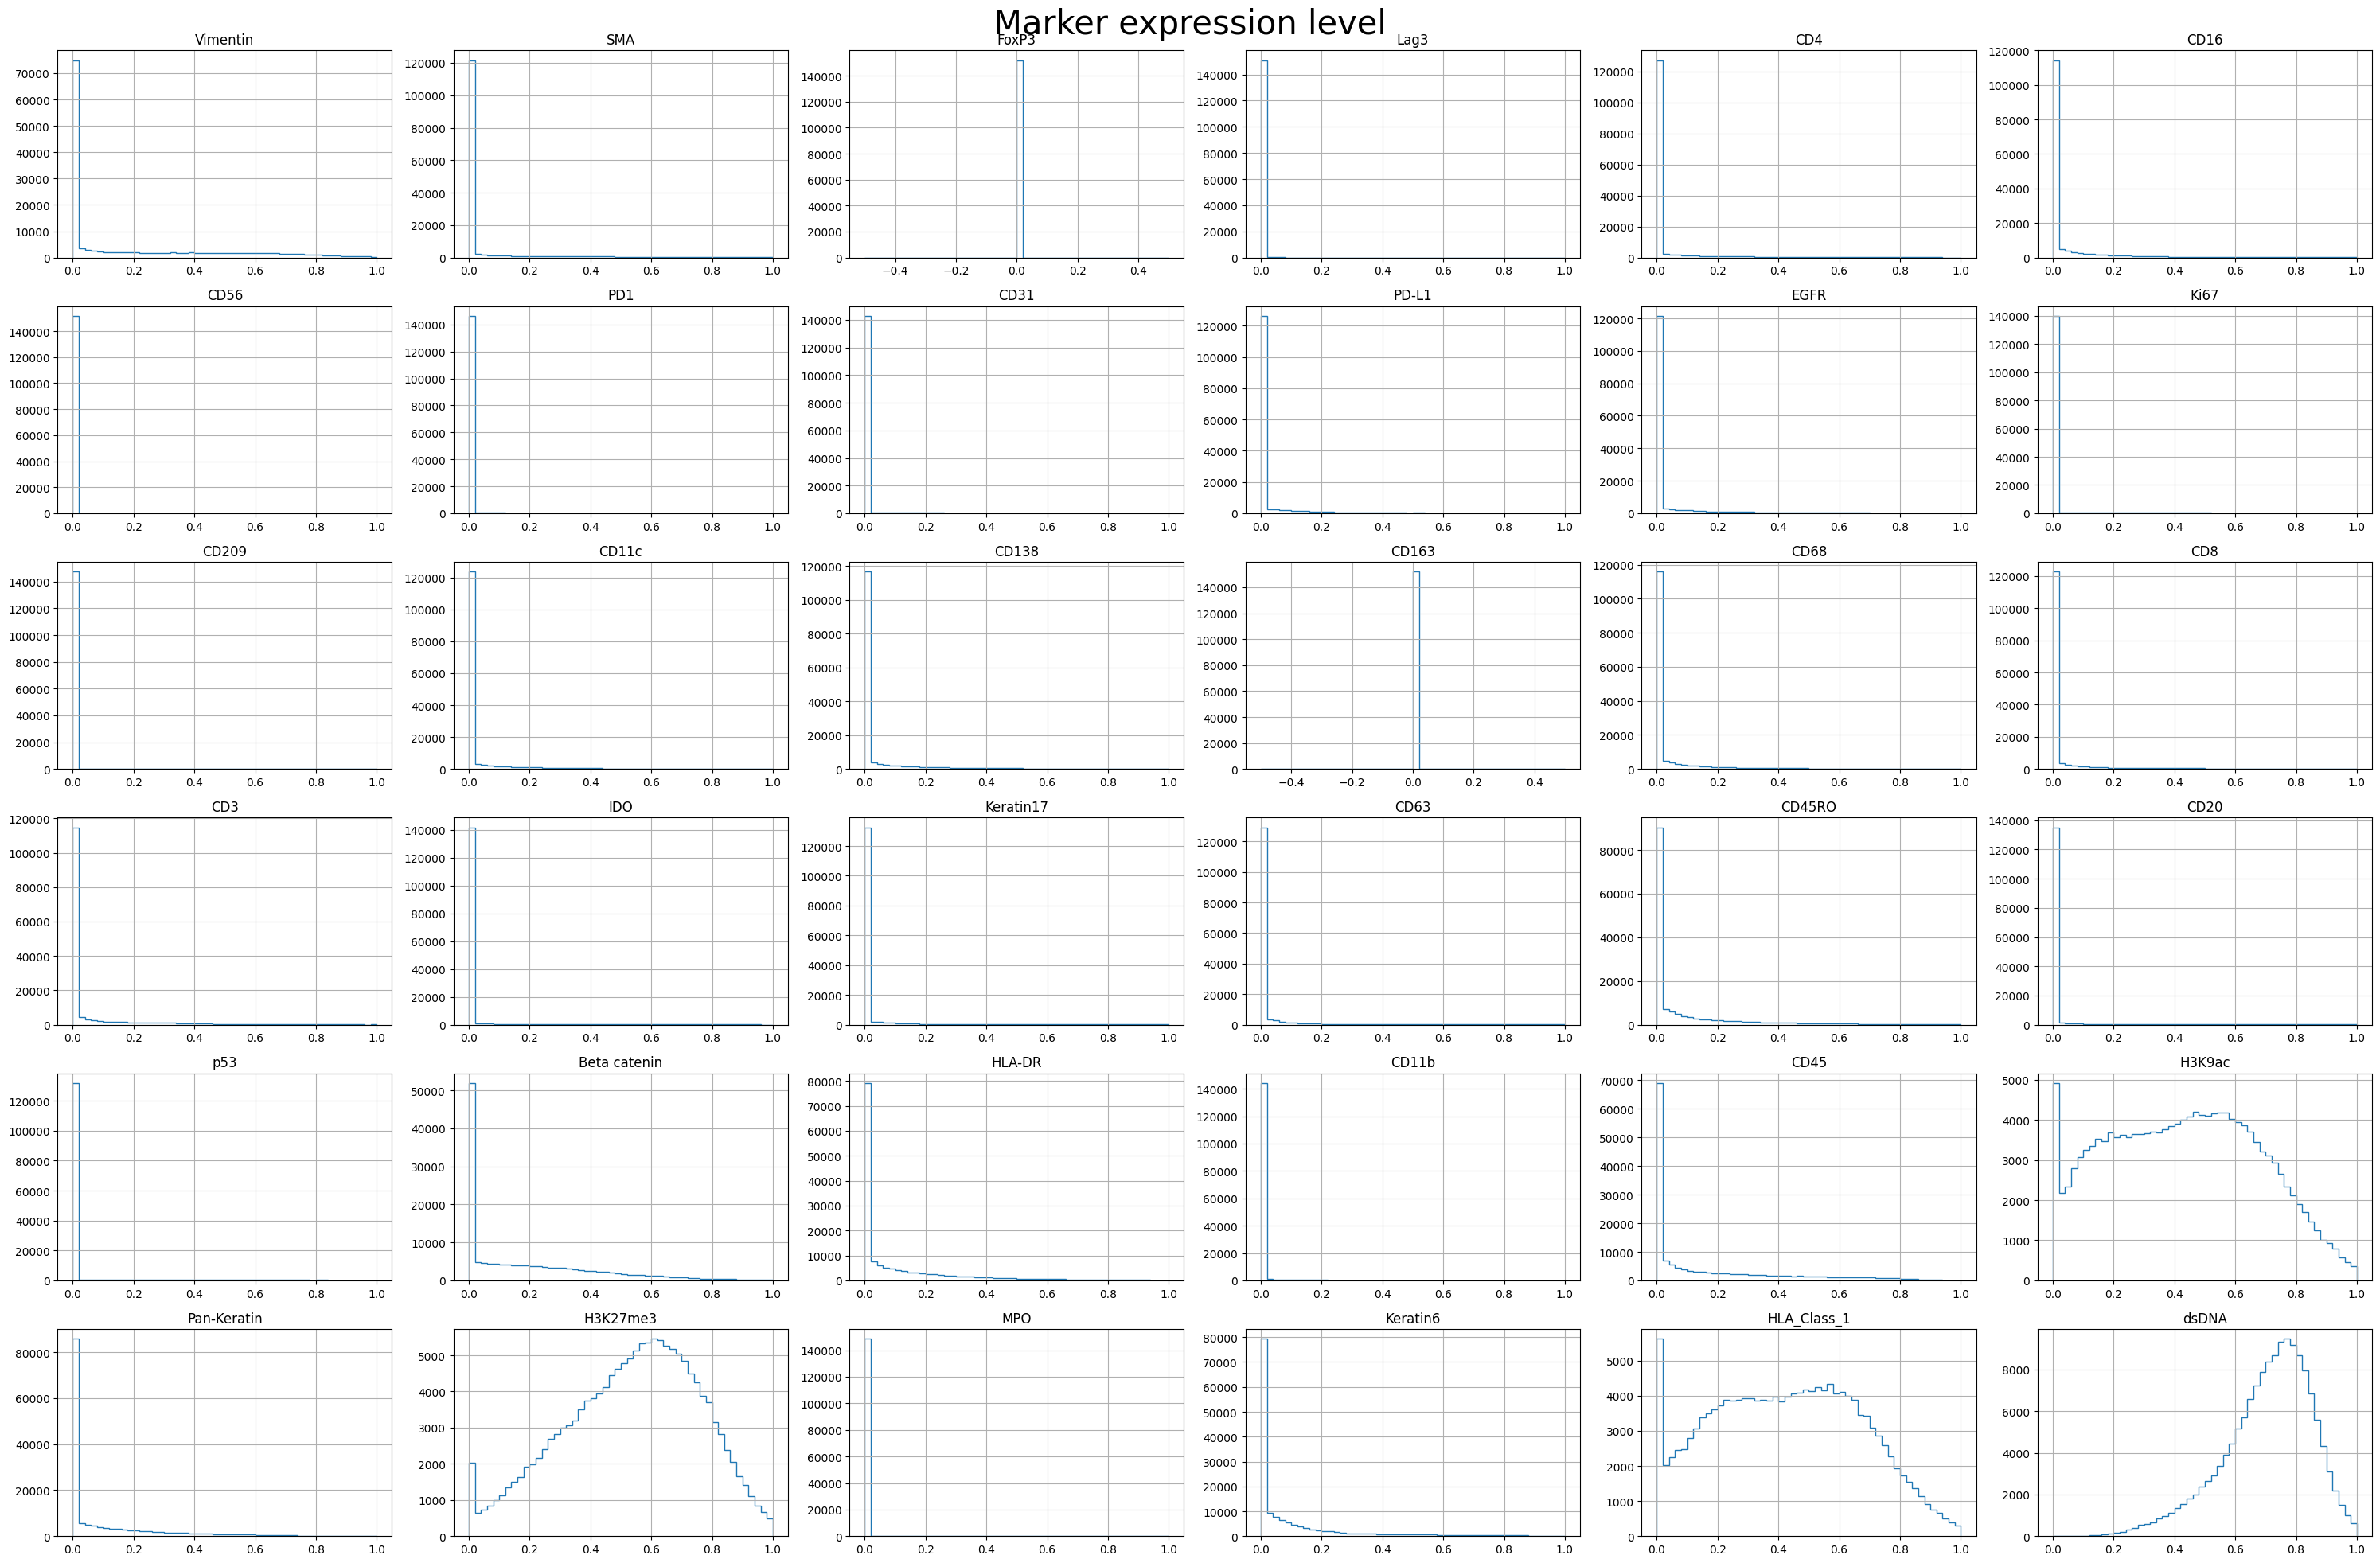

In [53]:
marker_expression(sample_data_scale[cols], markers=None, save=False, fname=None, dpi='figure', log=False)

## Marker quality check

In [18]:
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data.csv")
sample_data_qc = sample_data.drop(["SampleID", "cellLabelInImage","cellSize",
                                   "C","Na","Si","P","Ca", "Fe", "dsDNA", 
                                   "Background", "Ta", "Au", "tumorYN", 
                                   "B7H3", "OX40", "CSF-1R",
                                   "tumorCluster", "Group", "immuneCluster", 
                                   "immuneGroup","DetailedGroup", "upperGroup"], axis=1)

c:\Users\Public\Farkkila_lab_datasets\Tribus\tribus\tribus\visualization.py:211: RuntimeWarning: divide by zero encountered in log
  plt.stairs(np.log(hist)+sys.float_info.epsilon, edges, label="{}".format(uc))


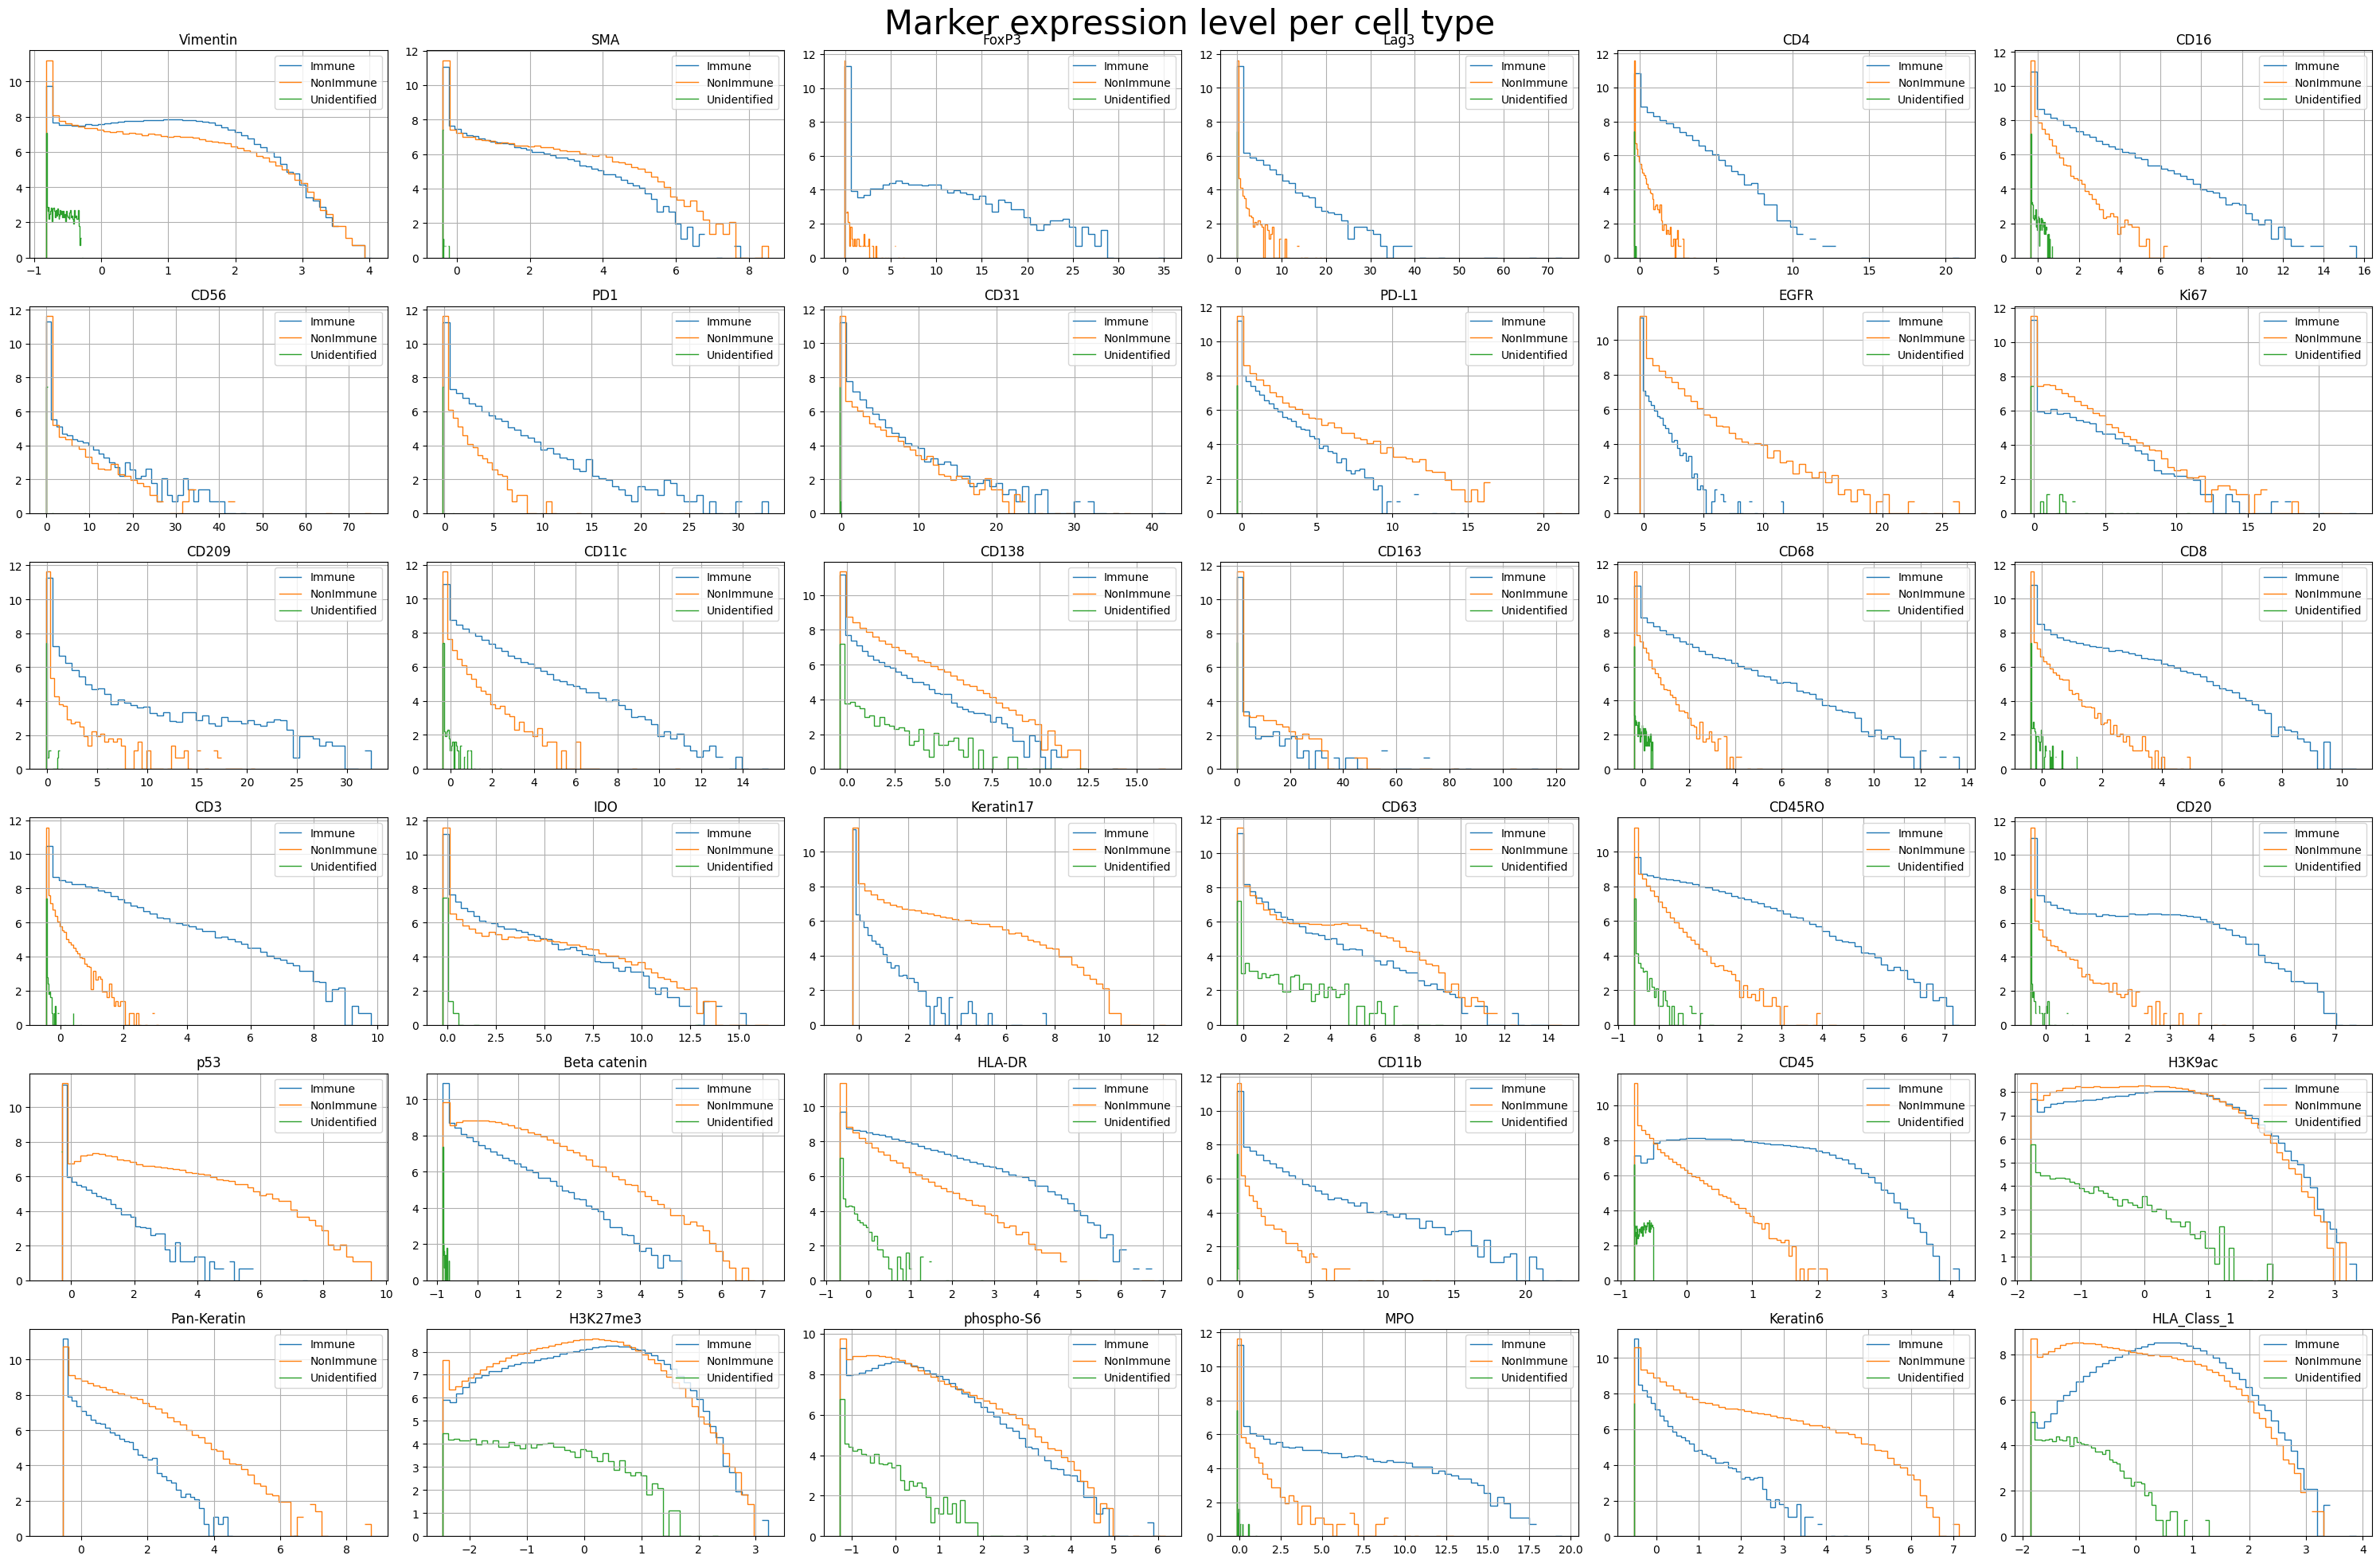

In [12]:
label = {'Global': sample_data['upperGroup']}
label = pd.DataFrame(label)

marker_expression_by_cell_type(sample_data_qc, label, cell_types=None, markers=None, level="Global", save=False, fname=None, dpi='figure', log=True)

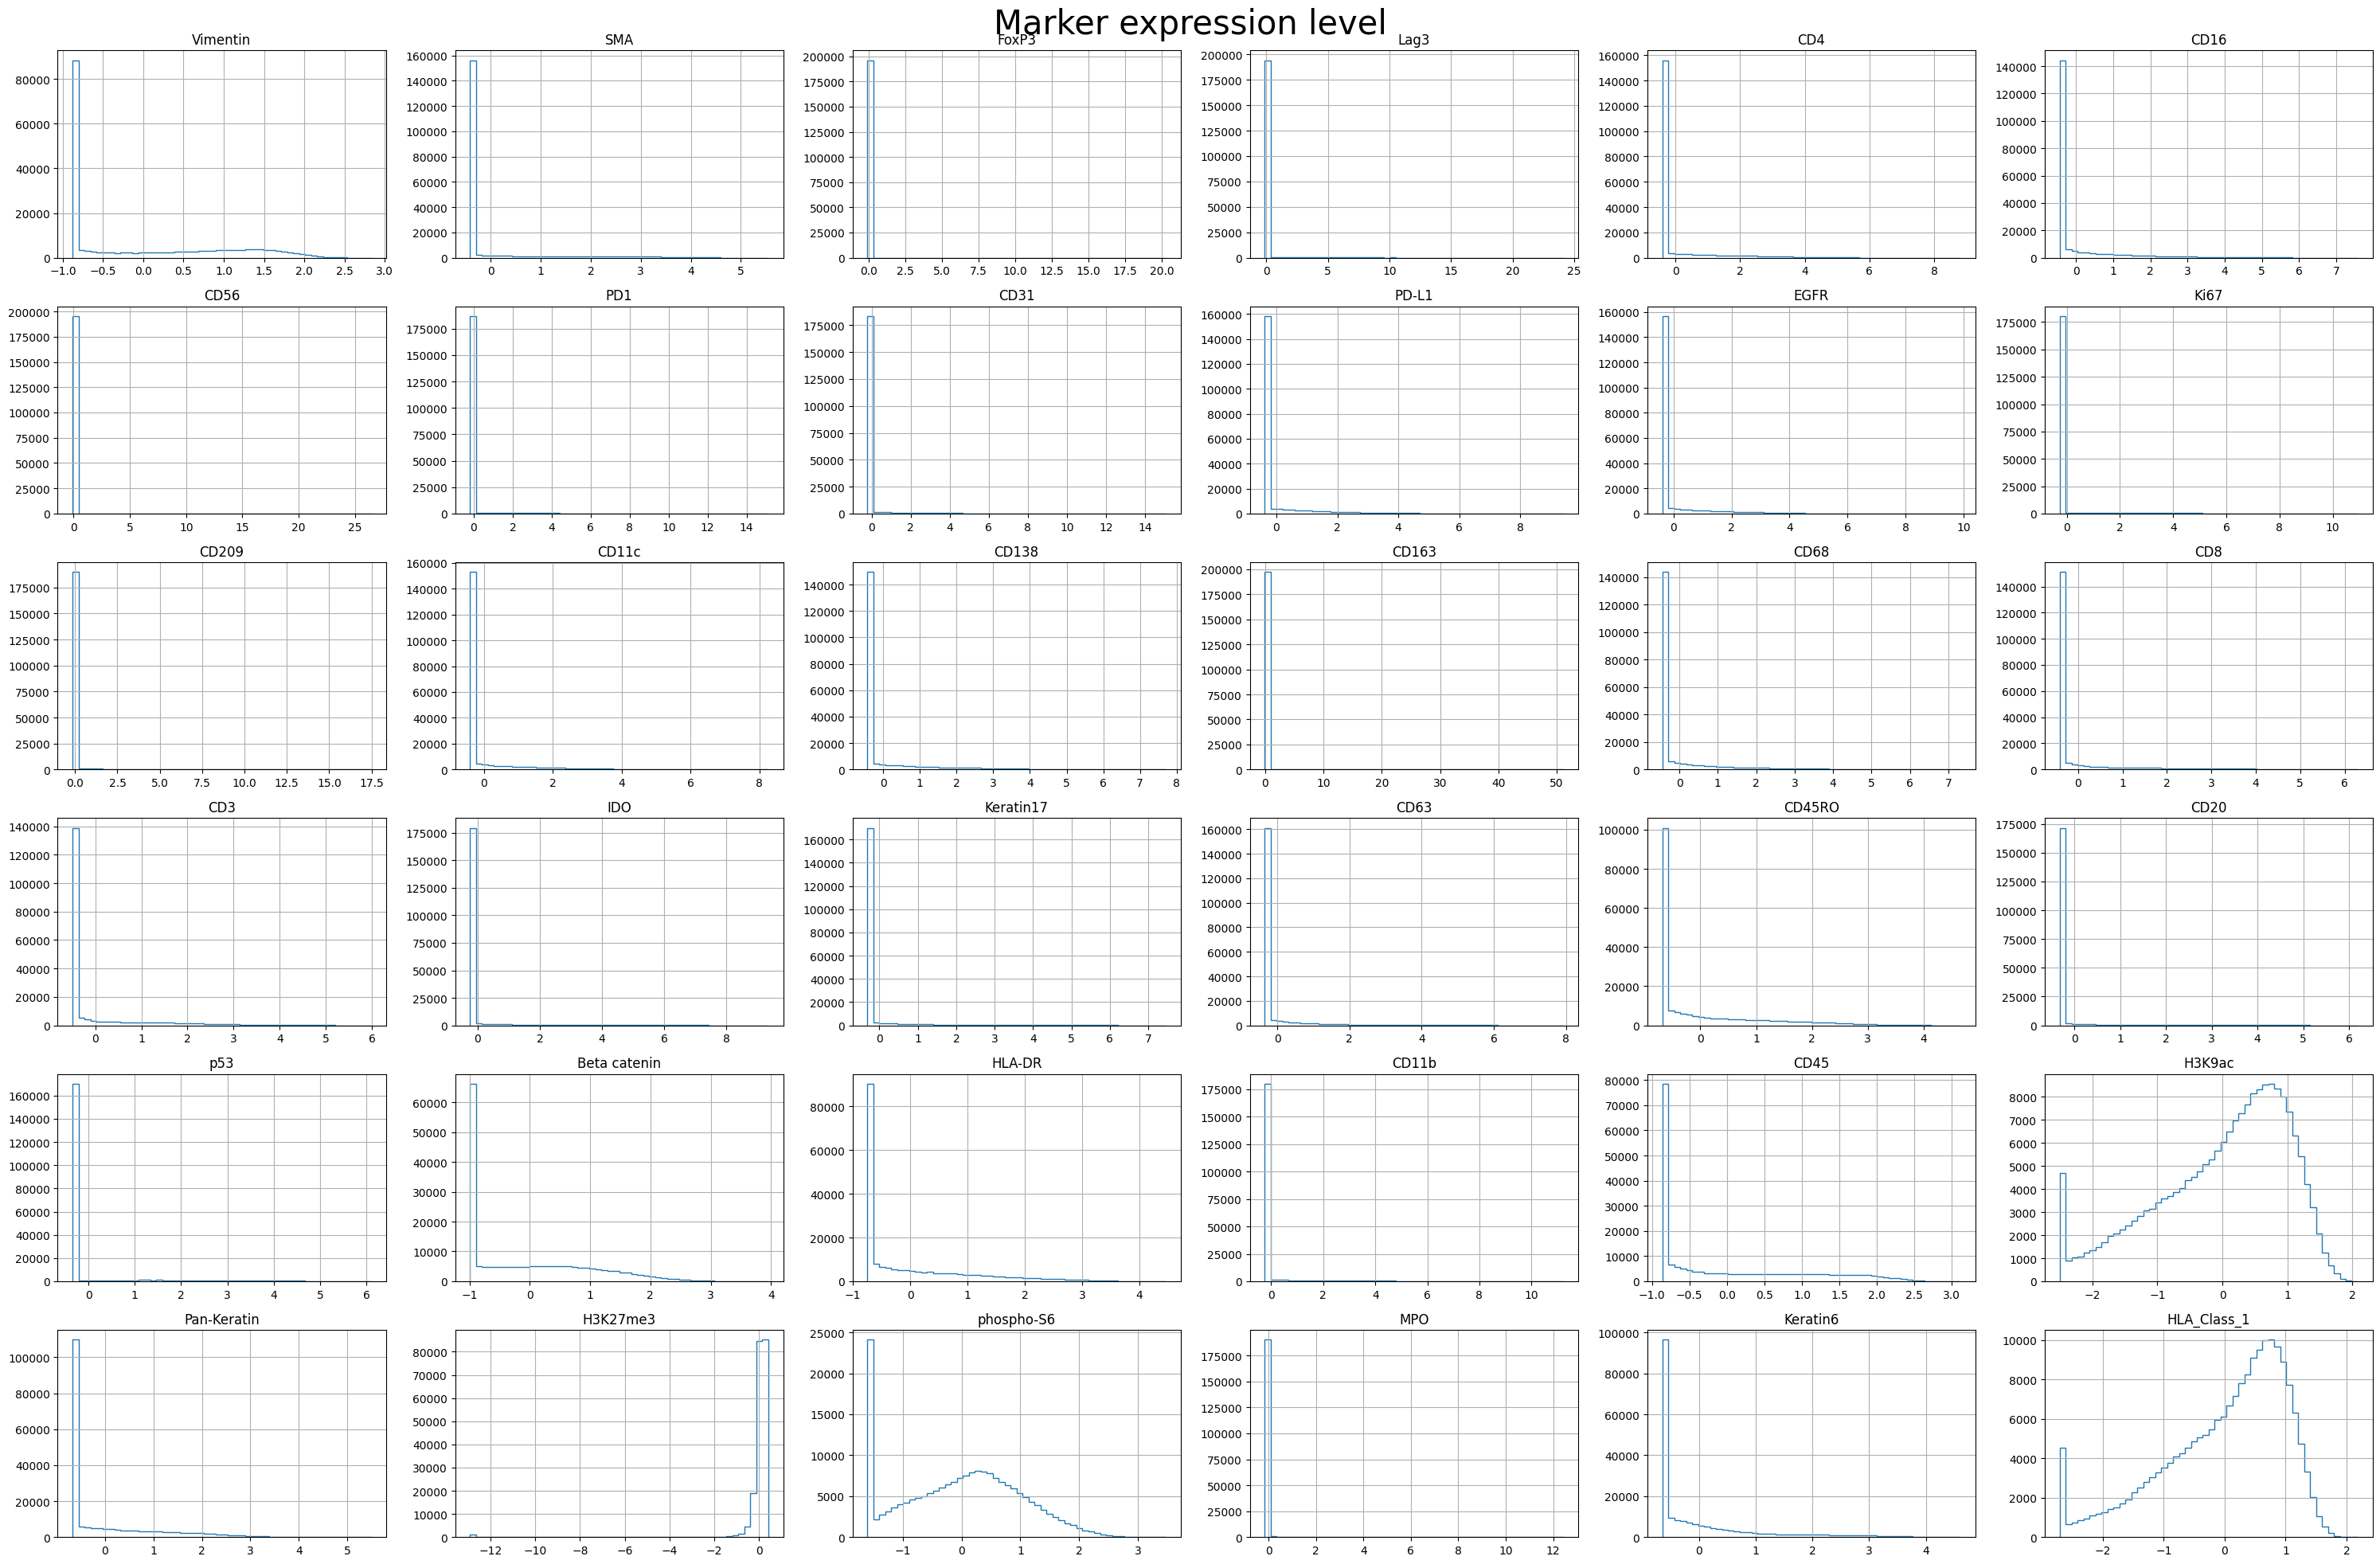

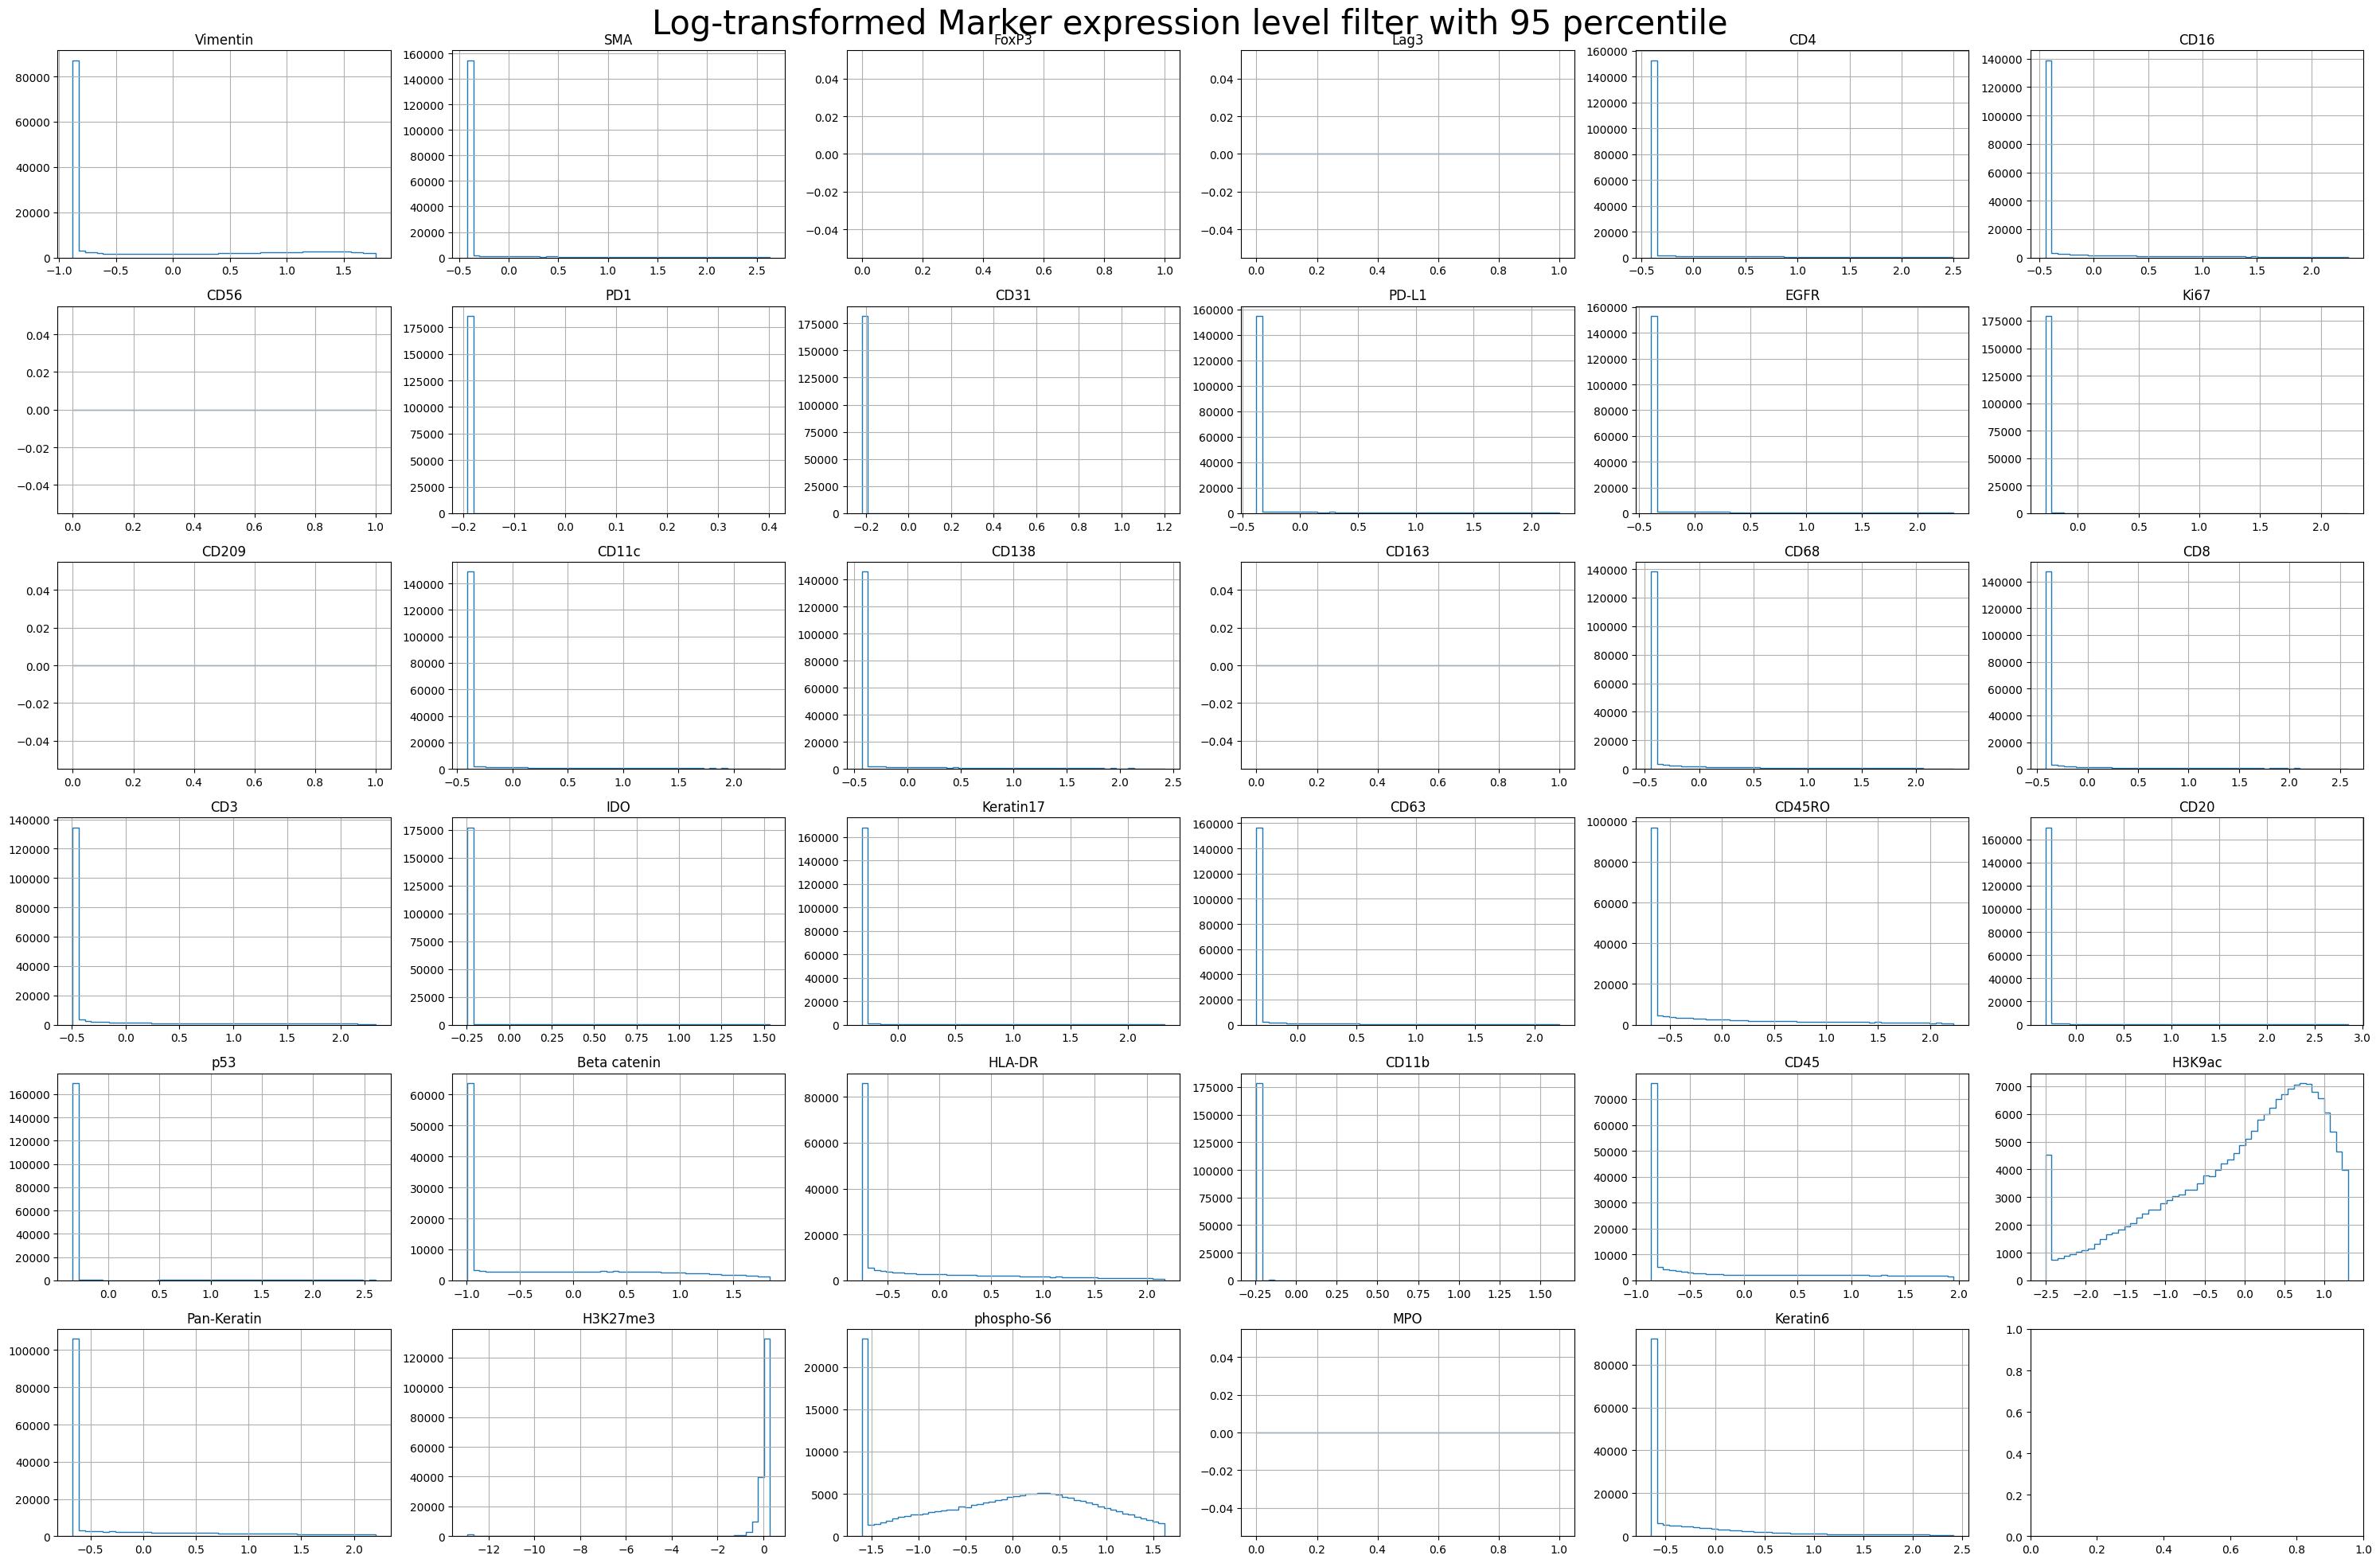

In [26]:
sample_data_log = z_score(np.log(sample_data_qc + abs(np.min(sample_data_qc)) + sys.float_info.epsilon))
marker_expression(sample_data_log, markers=None, save=False, fname=None, dpi='figure', log=False)

markers = sample_data_log.columns.values
fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Log-transformed Marker expression level filter with 95 percentile", fontsize=30)
for i in range(len(markers)-1): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    hist, edges = np.histogram(sample_data_log[markers[i]][sample_data_log[markers[i]] < np.percentile(sample_data_log[markers[i]],95)], 
                               bins=50)
    plt.stairs(hist, edges, label="{}".format(markers[i]))
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()

<Axes: >

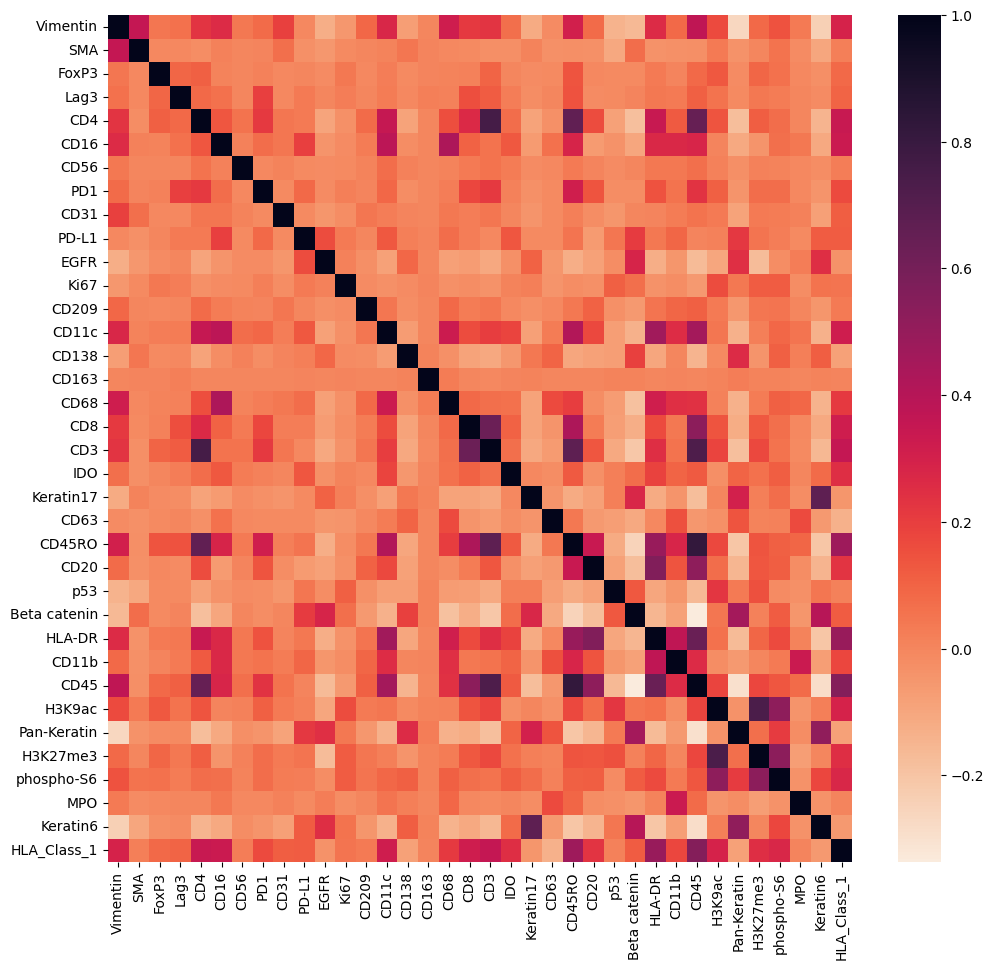

In [3]:
plt.figure(figsize=(12, 11))
sns.heatmap(sample_data_qc.corr(),cmap=sns.cm.rocket_r)

<Axes: >

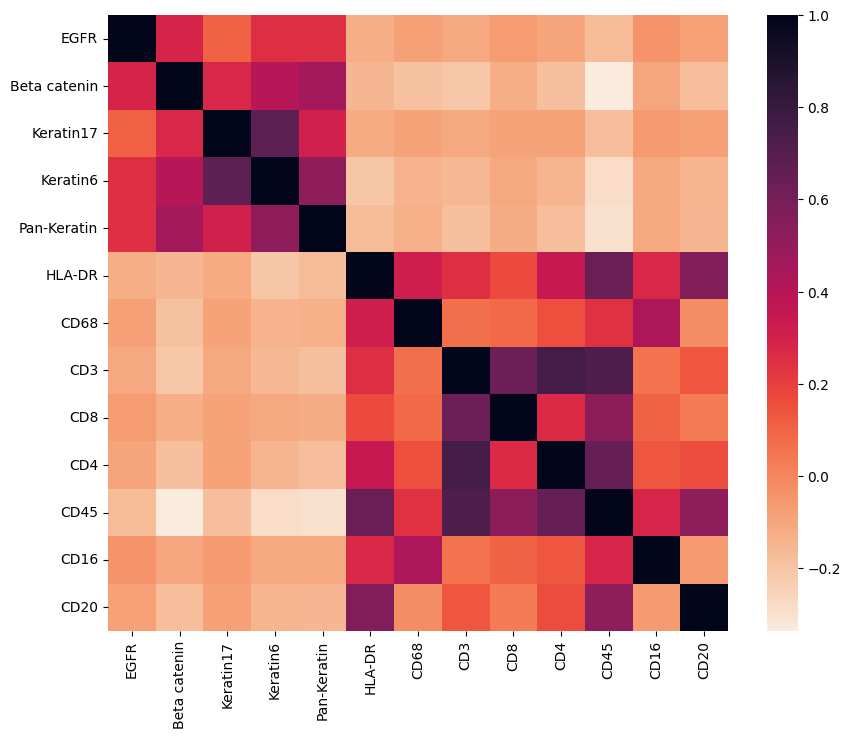

In [4]:
# check the marker correlation matrix we choose for the clustering method
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\logic_gate.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
marker_df = sample_data[logic["Global"]["Immune"].index]
plt.figure(figsize=(10,8))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

## Run Tribus on TNBC

In [2]:
# read input files
# no outlier filtering
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data_origin.csv")
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\logic_gate_updated.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)

<Axes: >

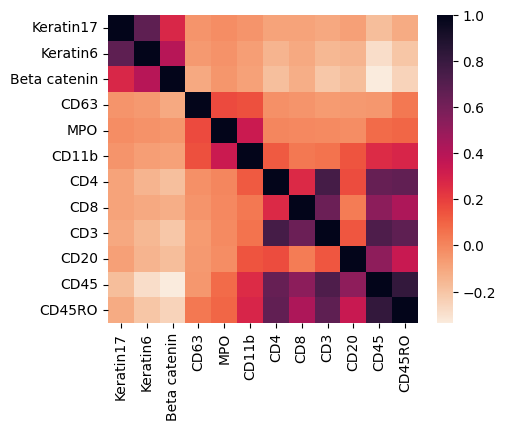

In [3]:
# check the marker correlation matrix we choose for the clustering method
marker_df = sample_data[logic["Global"].index]
plt.figure(figsize=(5,4))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

<Axes: >

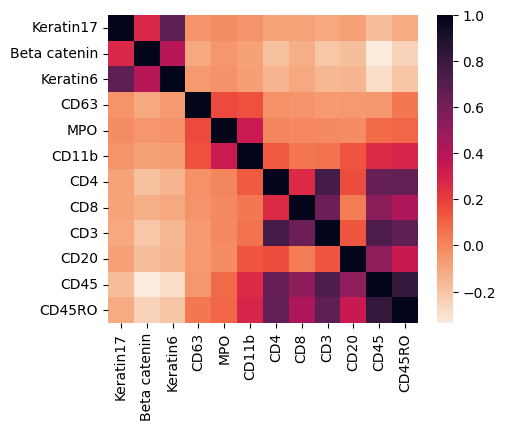

In [4]:
# check the marker correlation matrix for all markers
cols = ['Keratin17', 'Beta catenin', 'Keratin6',  
        'CD63', "MPO", 'CD11b',
        'CD4', 'CD8', 'CD3','CD20',"CD45","CD45RO"]
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data_origin.csv")

marker_df = sample_data[cols]
plt.figure(figsize=(5,4))
sns.heatmap(marker_df.corr(), cmap=sns.cm.rocket_r)

In [ ]:
all_cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
        'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
        'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
        'CD163','CD68', 'CD8', 'CD3', 'IDO', 
        'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
        'Beta catenin', 'HLA-DR', 'CD11b', 'CD45','H3K9ac', 
        'Pan-Keratin', 'H3K27me3', 'MPO','Keratin6', 'HLA_Class_1', 
        'dsDNA']

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(sample_data[all_cols], 40))

Global, subsetting done
Myeloid, subsetting done
5.556755848725637 minutes


<Axes: xlabel='Cell_type'>

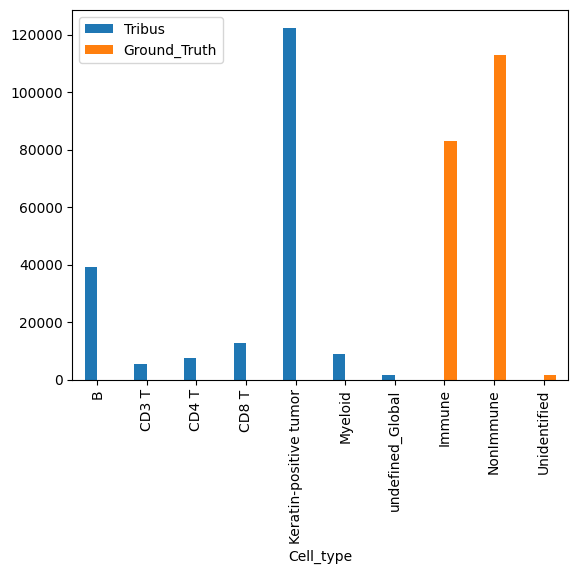

<Figure size 2000x600 with 0 Axes>

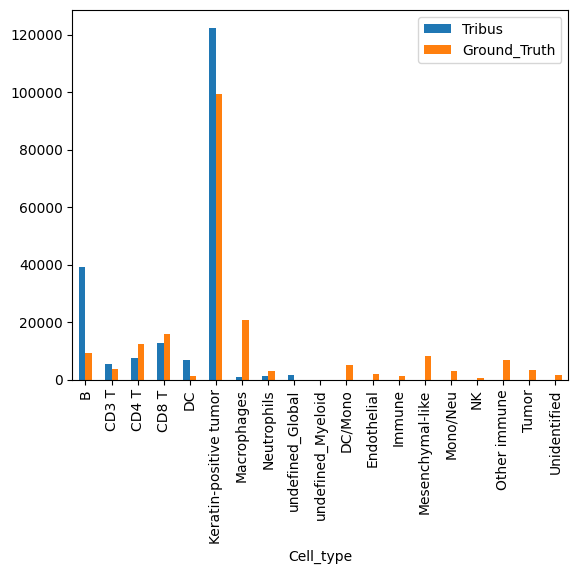

In [5]:
# Run Tribus on z-scored dataset

# Improve the result by checking the method part in paper: Cells with low expression across all markers used for clustering (sum < 0.1) were removed prior to clustering..
# Logic table need to be changed.
# MAX_PERCENTILE = 99
# REQUIRED_CELLS_FOR_CLUSTERING = 5000
# THRESHOLD_LOW = 0.001

depth = 2
labels, scores = run_tribus(sample_data, logic, depth=depth, normalization=z_score) # modify depth

# cell_type_distribution(labels, level="Global")
Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["Global"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["upperGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["final_label"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["DetailedGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

plt.figure(figsize=(20,6))
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

## Clustering quality check

<Axes: xlabel='Cell_type'>

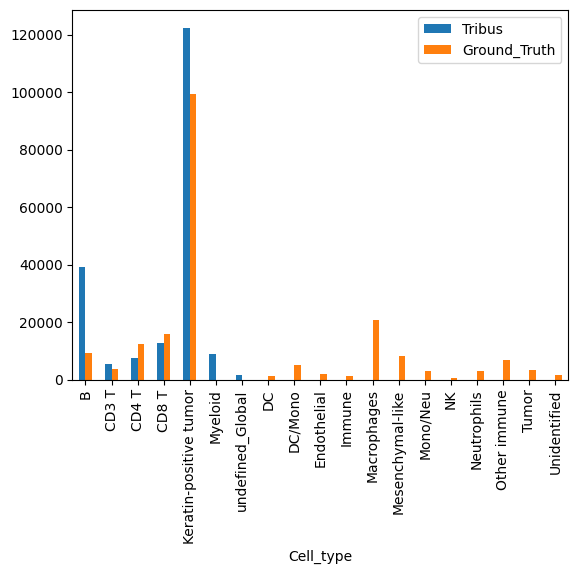

<Figure size 2000x600 with 0 Axes>

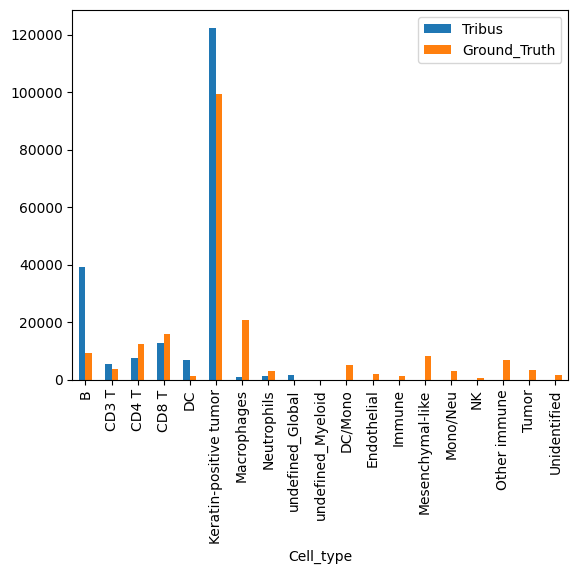

In [6]:
# cell_type_distribution(labels, level="Global")
Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["Global"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["DetailedGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["final_label"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["DetailedGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

plt.figure(figsize=(20,6))
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

In [ ]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=False, fname=None,
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_19440\3714587593.py:46: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7524447457839977, Accuracy score = 0.6057679660862615, Precision score = 0.6157019094268855, F1 score = 0.5466160475701758


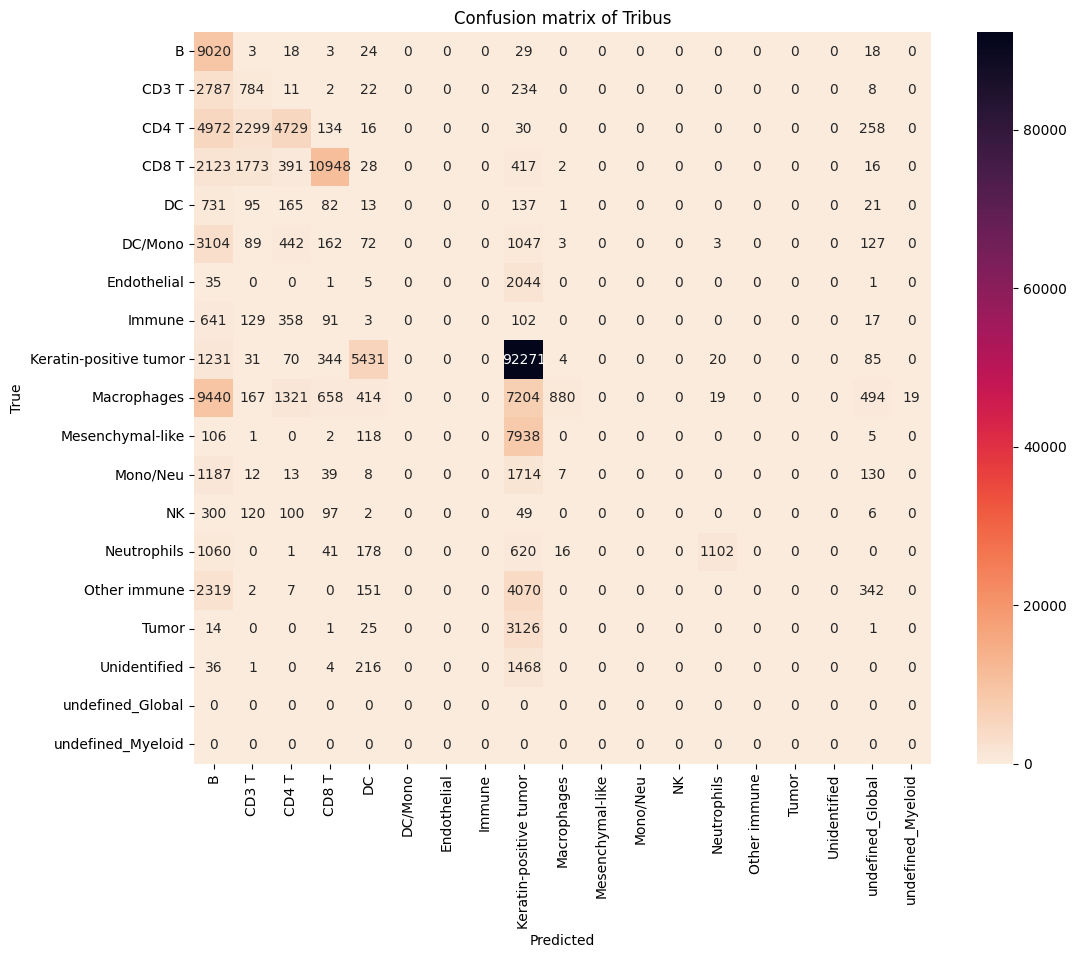

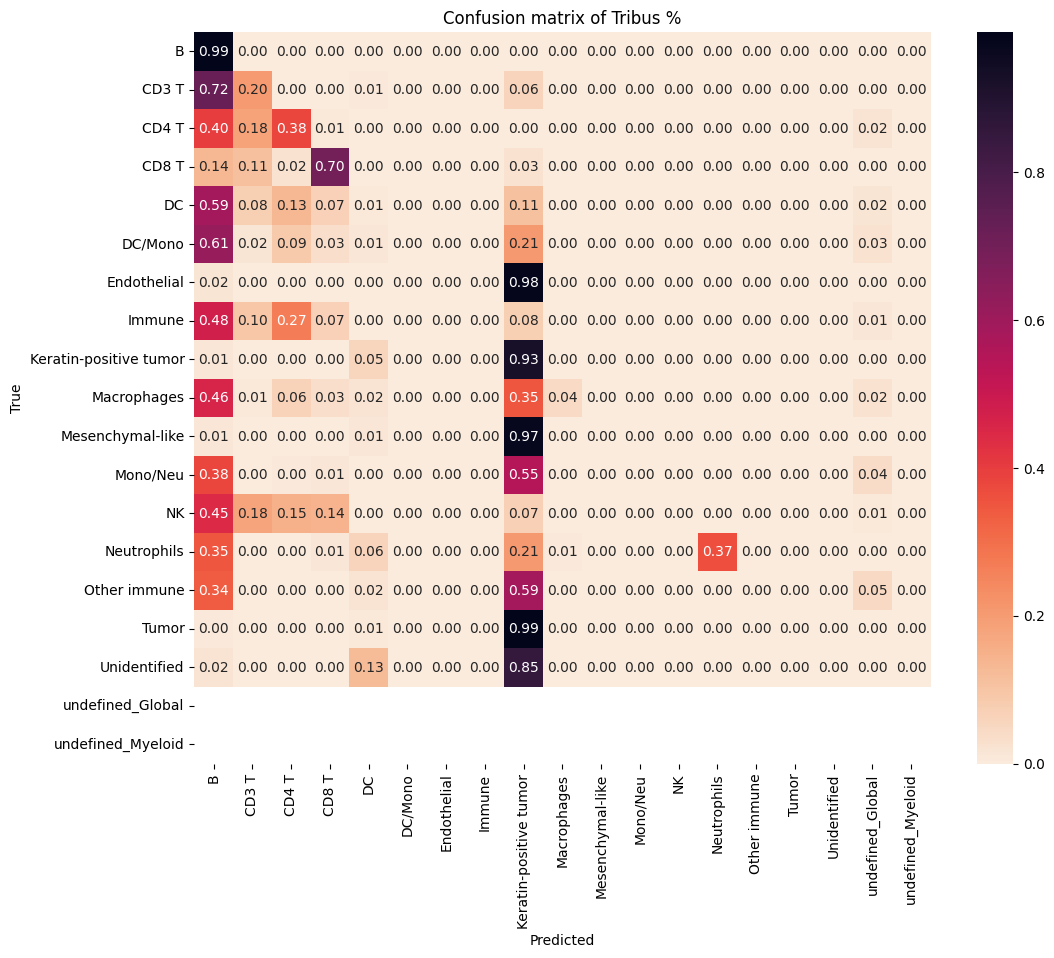

In [7]:
# confusion matrix
if depth == 1: 
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    # cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm_labels = np.union1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
else:
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
        # cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm_labels = np.union1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')

RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7524447457839977, Accuracy score = 0.6057679660862615, Precision score = 0.6157019094268855, F1 score = 0.5466160475701758


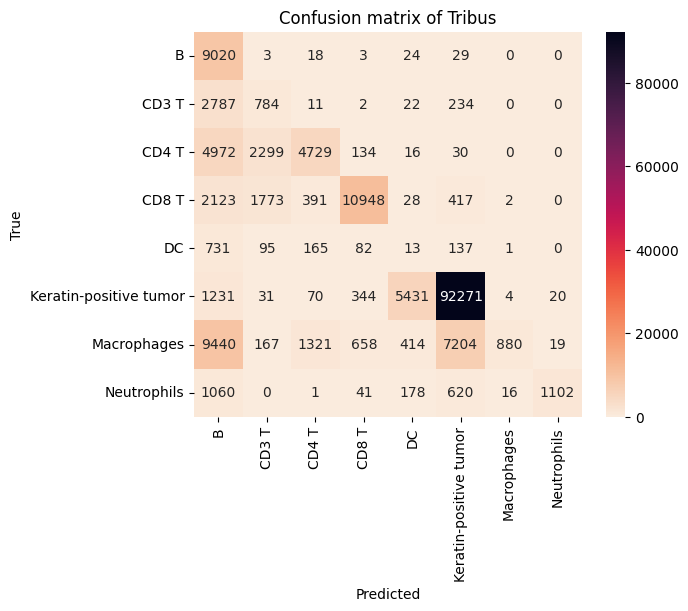

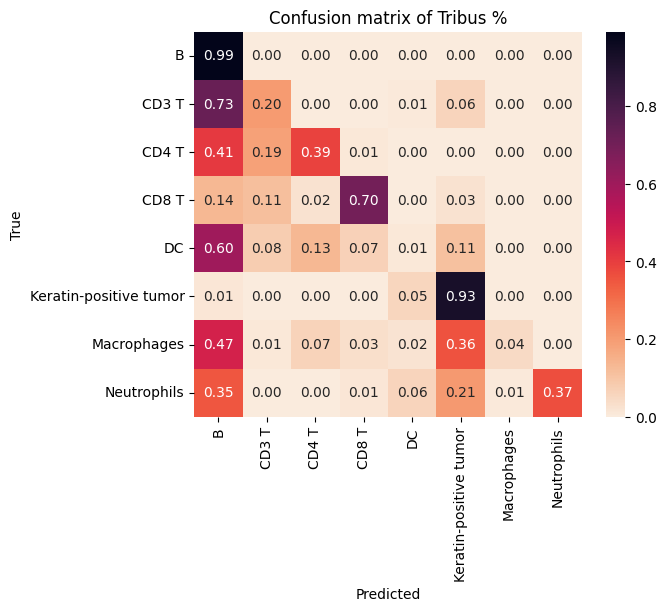

In [8]:
# confusion matrix
if depth == 1: 
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
else:
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')

RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

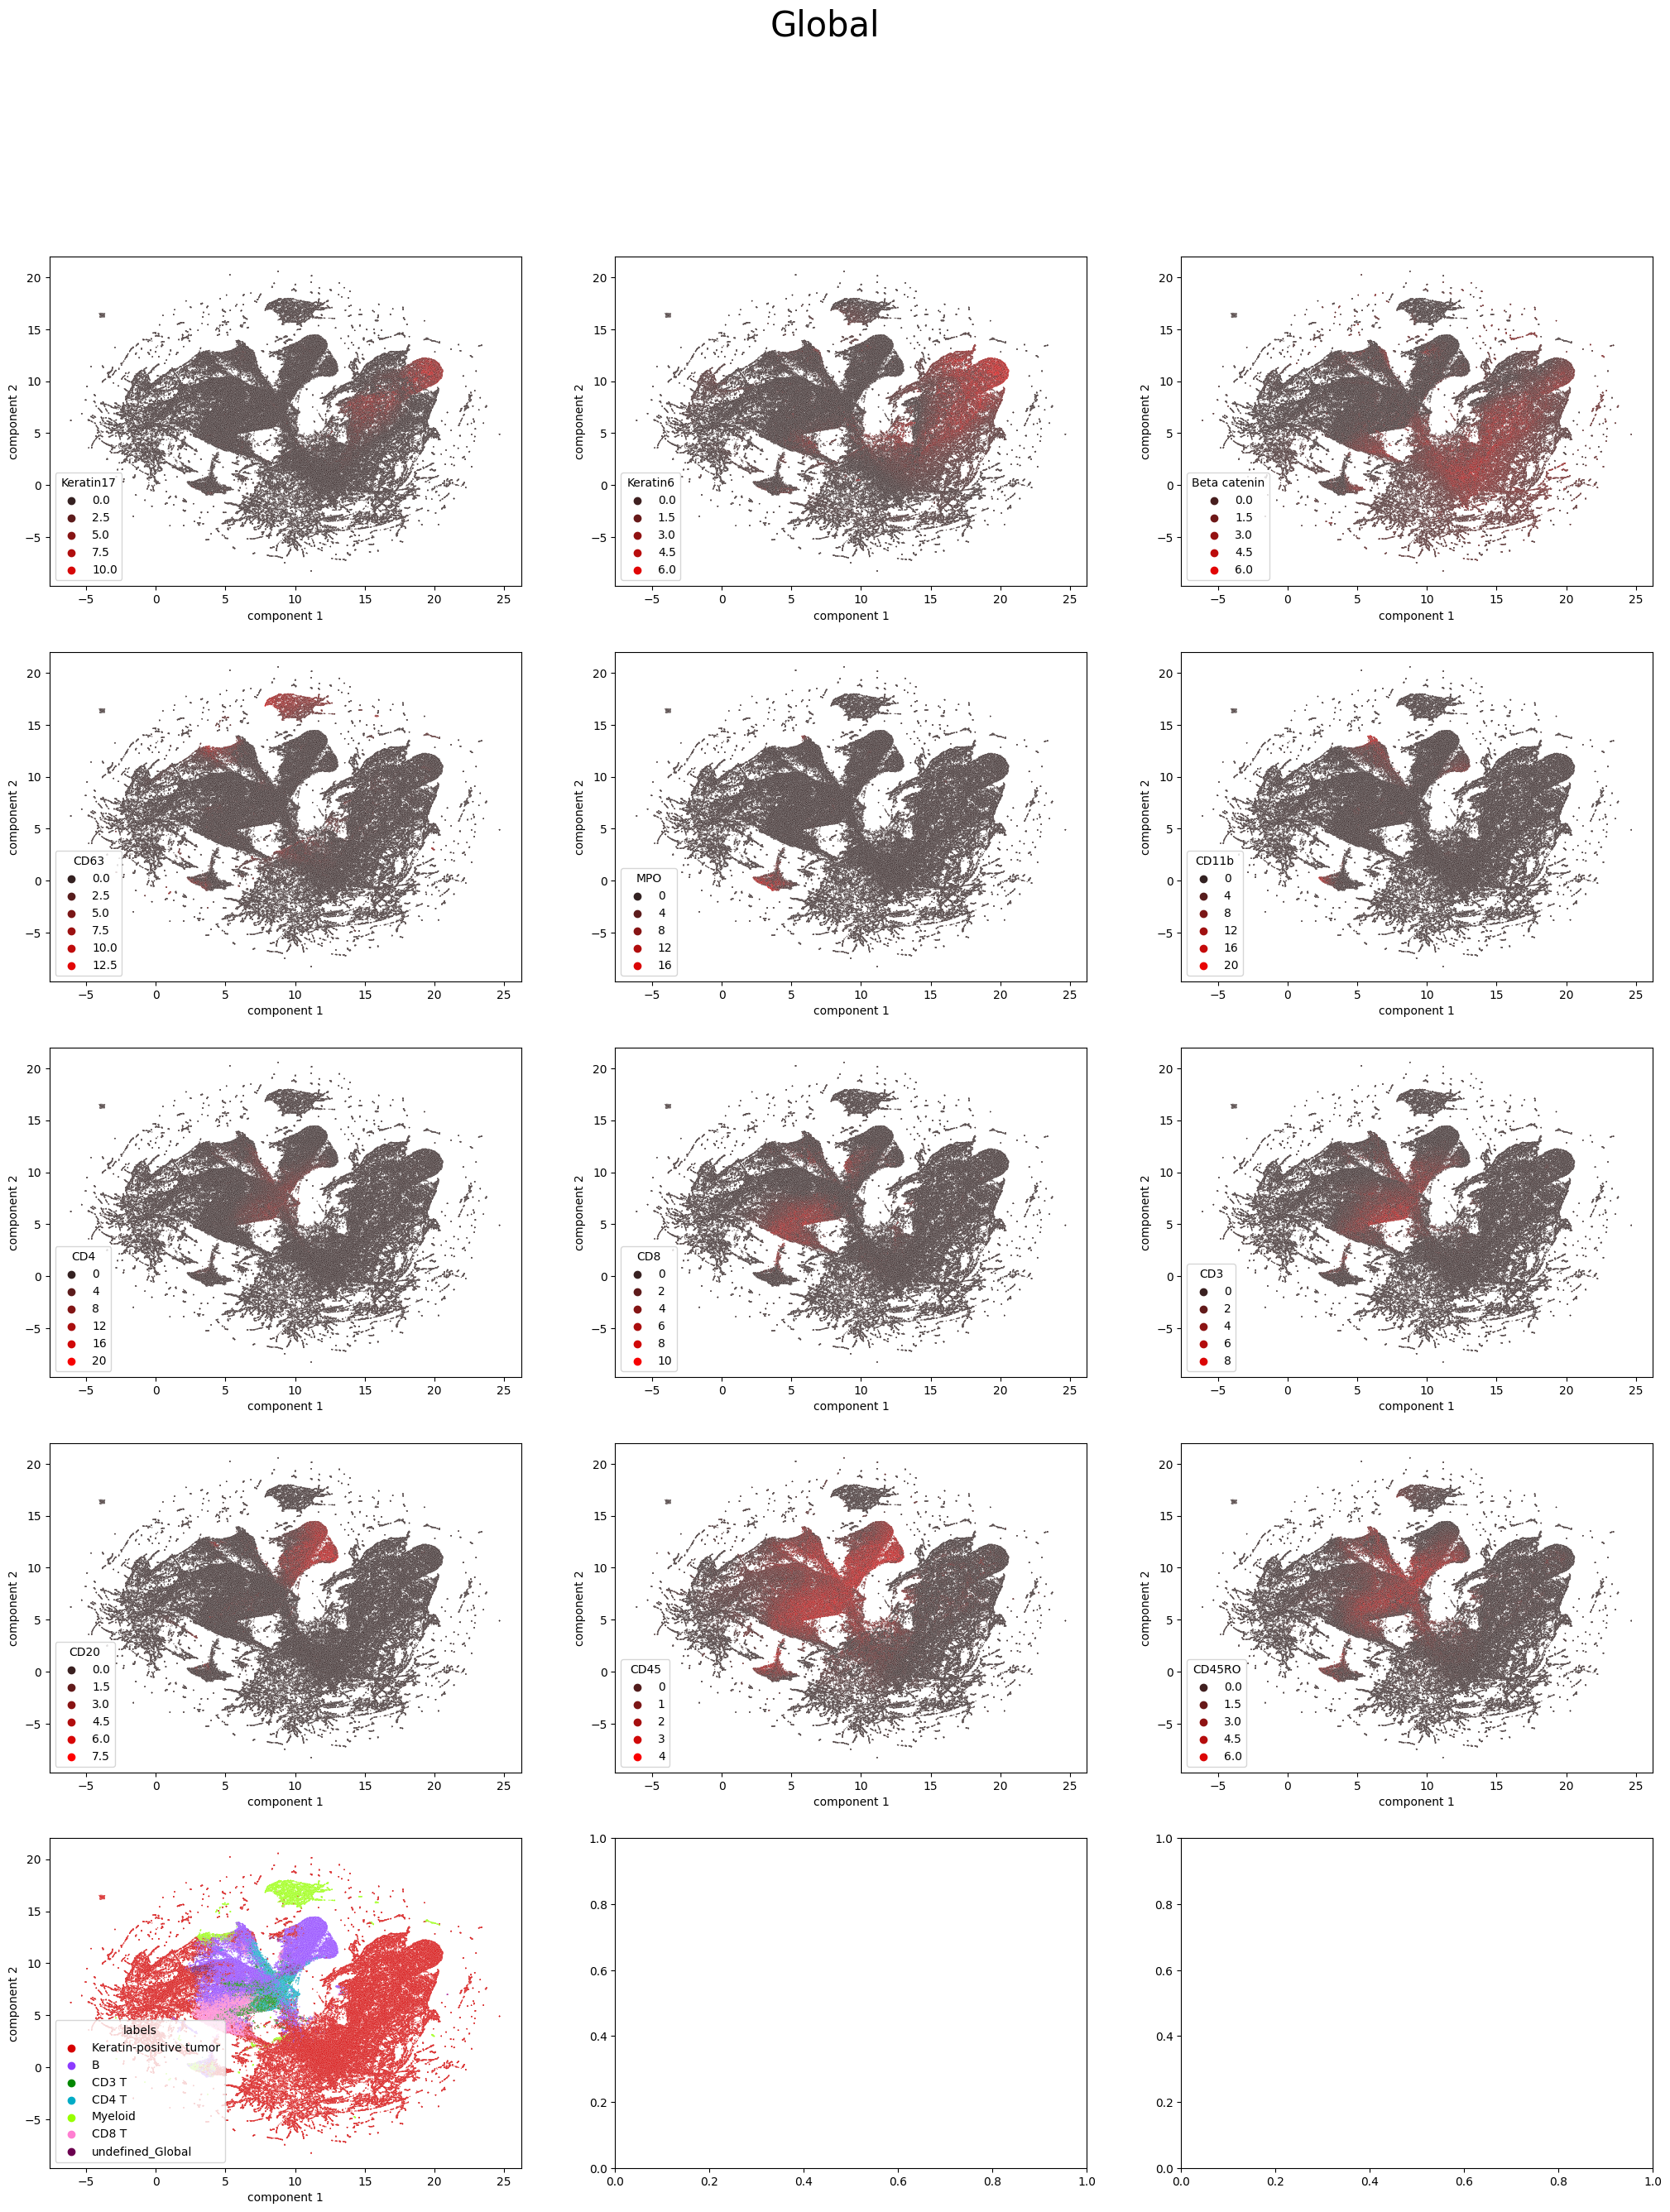

In [9]:
# scale the dataset into (0,1) before UMAP
#scaler = MinMaxScaler() 
#arr_scaled = scaler.fit_transform(sample_data)
#sample_data_scaled = pd.DataFrame(arr_scaled, columns=sample_data.columns,index=sample_data.index)

umap_vis(sample_data, labels, markers=logic["Global"].index.values.tolist(), save=False, fname=None,  level="Global", title=None, init='spectral',
             random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation', palette_markers='mycolormap',
             palette_cell='tab10', dpi='figure')